In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [3]:
hdf_dir = Path("../data")

In [4]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [5]:
fname = "2021_3_23.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<60} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1616513558 scan R0 F1                                        : 481
1  <> 1616514118 scan P2 F1                                        : 641
2  <> 1616514738 scan P2 F1                                        : 641
3  <> 1616525363 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) : 1
4  <> 1616525381 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) : 931
5  <> 1616526178 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) : 3041
6  <> 1616527534 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) no DET phase modulation : 1
7  <> 1616528084 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) no DET phase modulation : 1601
8  <> 1616528669 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) with DET phase modulation : 2401
9  <> 1616529581 scan R0 F1 with shutter (R0 F1 DET P2 F1 RC and J12 J23 microwaves) with DET and RC phase modulation : 2401
10 <> 1616531576 scan P2 F2 with shutter (R0 F1 DET P2 F1 RC and J12 J23 microwaves) with D

## With DET and RC phase modulation
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [133]:
dset_name = dset_names[5]
devices = ()

In [134]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [135]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

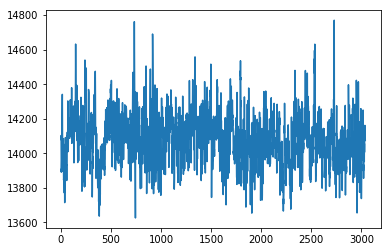

In [136]:
plt.plot(pdn_data.mean(axis = 1))

In [137]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [138]:
yag_cutoff = 250
ptn_cutoff = 13000
abs_cutoff = 4
fl_cutoff = -5000

In [139]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

39.4% data discarded


In [140]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

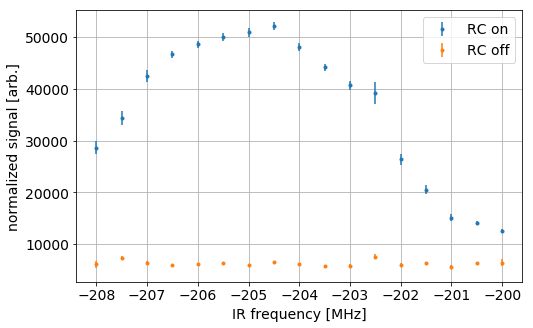

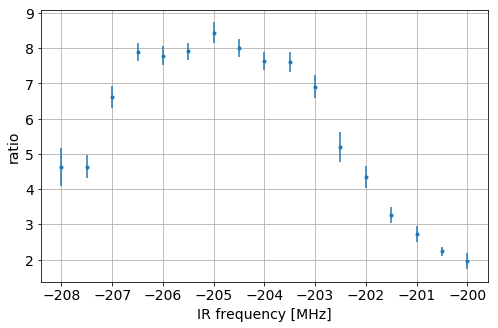

In [141]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [142]:
data_ϕmod_det = [bin_means, results, (ratio, err)]

## With RC phase modulation, no DET phase modulation
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [143]:
dset_name = dset_names[7]
devices = ()

In [144]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [145]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

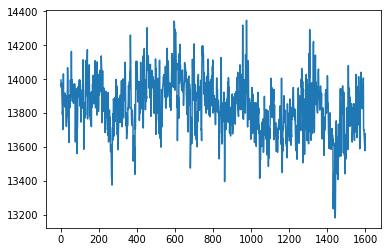

In [146]:
plt.plot(pdn_data.mean(axis = 1))

In [147]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [148]:
yag_cutoff = 250
ptn_cutoff = 13000
abs_cutoff = 4
fl_cutoff = -5000

In [149]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

42.1% data discarded


In [150]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

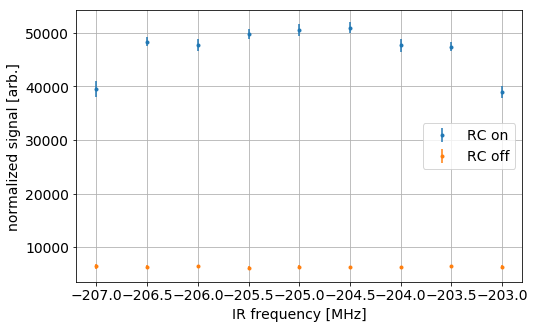

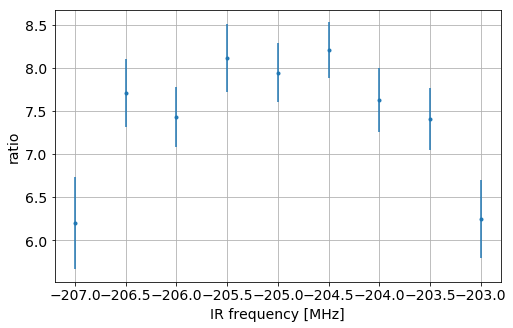

In [151]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

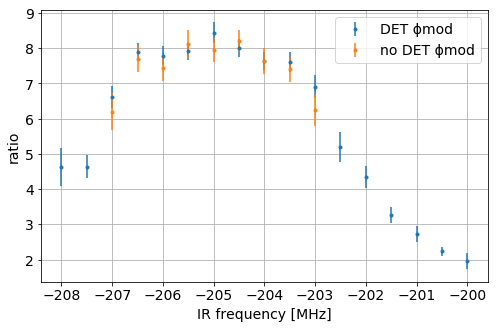

In [152]:
fig, ax = plt.subplots(figsize = (8,5))

bm = data_ϕmod_det[0]
r, rerr = data_ϕmod_det[2]

ax.errorbar(bm, r, yerr = rerr, fmt = '.', label = 'DET ϕmod')
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.', label = 'no DET ϕmod')
ax.legend(fontsize = 14)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)


## With RC phase modulation, with DET phase modulation, DET power to 50 mW
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [153]:
dset_name = dset_names[8]
devices = ()

In [154]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616528668.7400258
run_description           -> scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves)
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 37 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 27 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [155]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [156]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

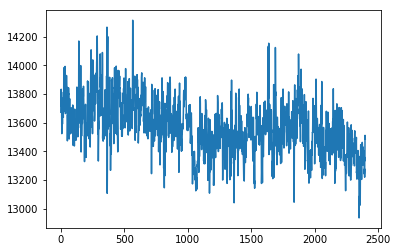

In [157]:
plt.plot(pdn_data.mean(axis = 1))

In [158]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [159]:
yag_cutoff = 250
ptn_cutoff = 13000
abs_cutoff = 4
fl_cutoff = -5000

In [160]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

33.7% data discarded


In [161]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

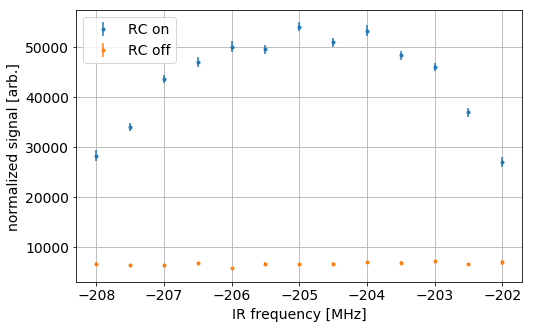

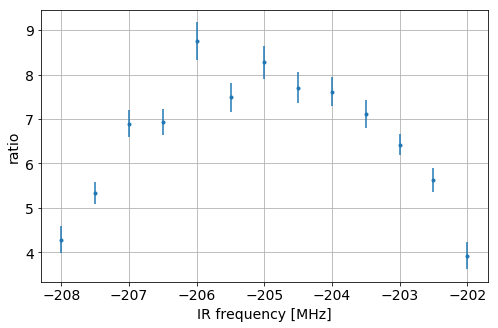

In [162]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R0 F1 with RC phase modulation, with DET phase modulation, DET power to 50 mW
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [163]:
dset_name = dset_names[9]
devices = ()

In [164]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616529579.9294093
run_description           -> scan R0 F1 with shutter (R0 F1 DET P2 F1 RC and J12 J23 microwaves) with DET and RC phase modulation
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 37 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 27 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [165]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [166]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

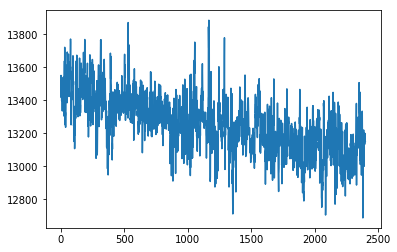

In [167]:
plt.plot(pdn_data.mean(axis = 1))

In [168]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [169]:
yag_cutoff = 250
ptn_cutoff = 13000
abs_cutoff = 4
fl_cutoff = -5000

In [170]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

56.5% data discarded


In [171]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

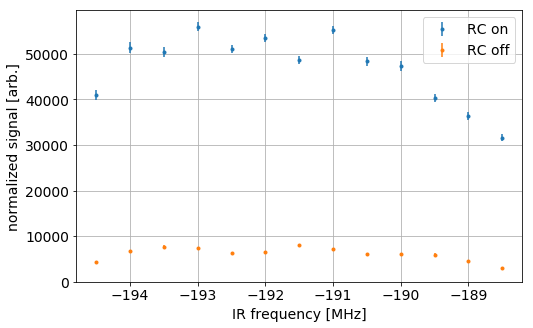

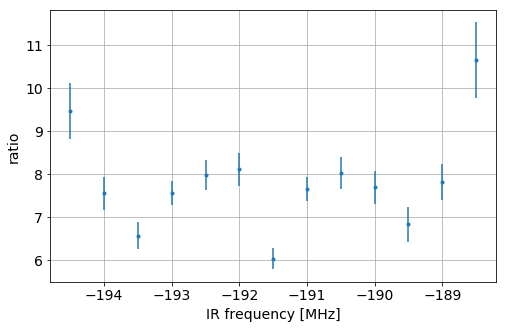

In [172]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan P2 F1 with RC phase modulation, with DET phase modulation, DET power to 50 mW & RC power to 47 mW
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [173]:
dset_name = dset_names[10]
devices = ()

In [174]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616531575.0945203
run_description           -> scan R0 F1 with shutter (R0 F1 DET P2 F1 RC and J12 J23 microwaves) with DET and RC phase modulation
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 47 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 27 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [175]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [176]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

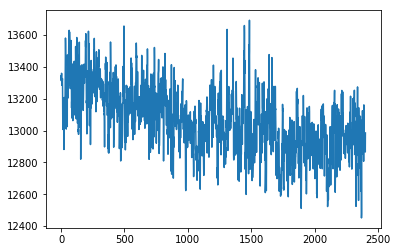

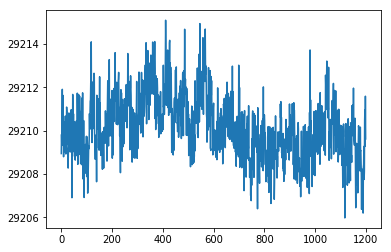

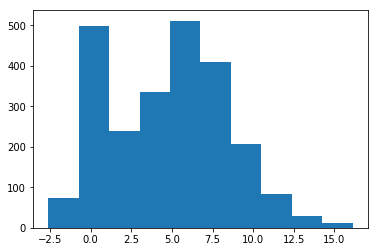

In [177]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(shutter_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]));

In [178]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [187]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 4
fl_cutoff = -5000

In [188]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

39.8% data discarded


In [189]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

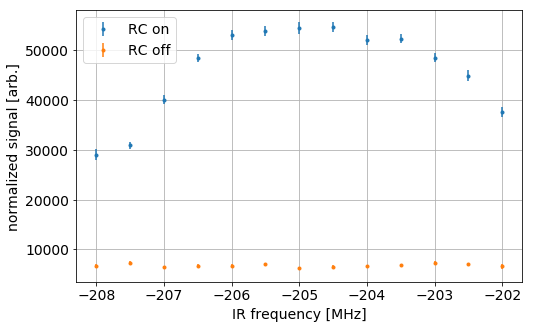

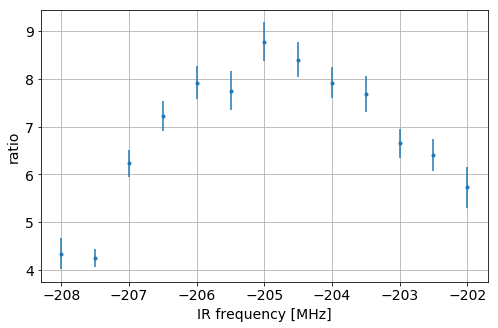

In [190]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan P2 F1 with RC phase modulation, with DET phase modulation, DET power to 50 mW & RC power to 47 mW
## DET angle slightly changed to overlap more
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [192]:
dset_name = dset_names[11]
devices = ()

In [193]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616532463.3474596
run_description           -> scan P2 F2 with shutter (R0 F1 DET P2 F1 RC and J12 J23 microwaves) with DET and RC phase modulation DET angle slightly changed
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 47 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 27 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [194]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [195]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

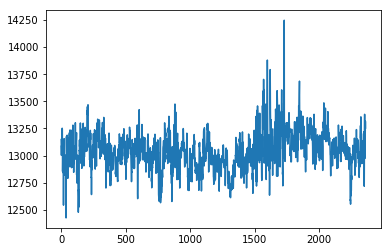

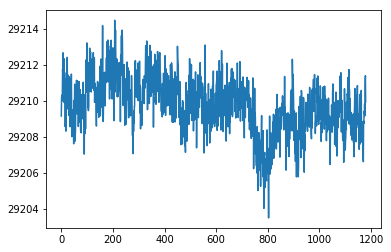

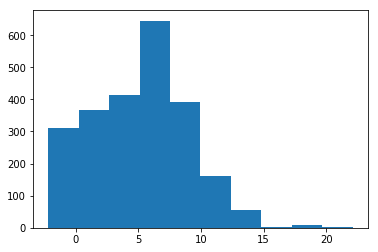

In [196]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(shutter_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]));

In [197]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [206]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 4
fl_cutoff = -5000

In [207]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

36.7% data discarded


In [208]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

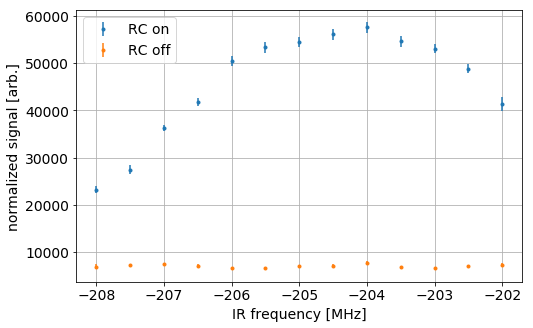

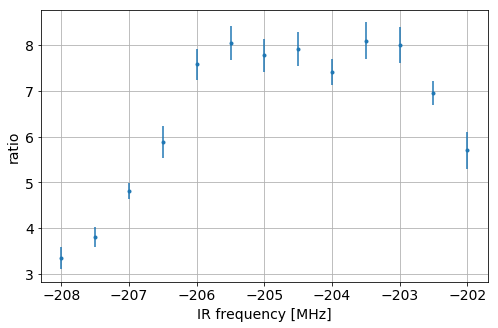

In [209]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan J12 microwave power
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [277]:
dset_name = dset_names[12]
devices = ()

In [278]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616533376.0607536
run_description           -> scan microwave power with phase modulation on RC and DET (R0 F1 DET P2 F1 RC J12 J23 microwaves)
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 47 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 27 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [279]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [280]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

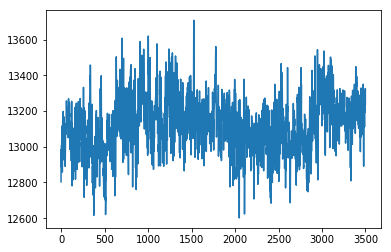

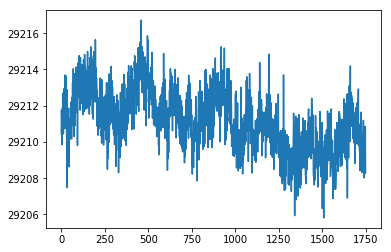

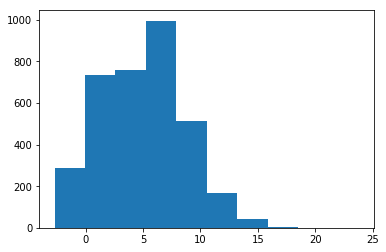

In [281]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(shutter_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]));

In [282]:
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [283]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 4
fl_cutoff = -5000

In [284]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

38.8% data discarded


In [285]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

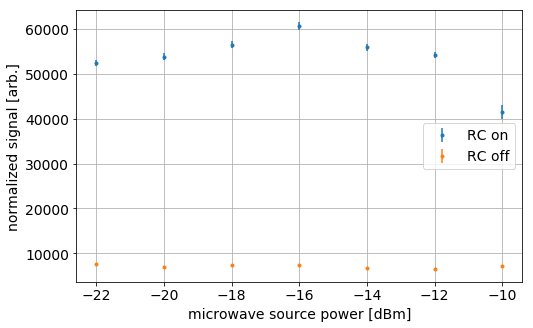

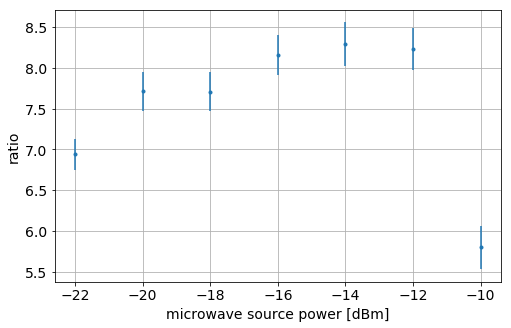

In [287]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('microwave source power [dBm]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan J12 microwave power (replaced PSU that was overloading and causing problems)
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [288]:
dset_name = dset_names[14]
devices = ()

In [289]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616534430.2523625
run_description           -> scan microwave power J23 with phase modulation on RC and DET (R0 F1 DET P2 F1 RC J12 J23 microwaves)
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 47 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 26 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [290]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [291]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

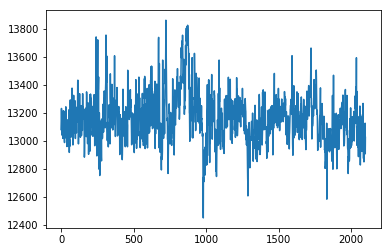

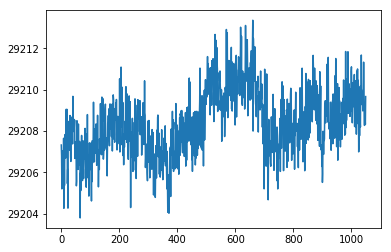

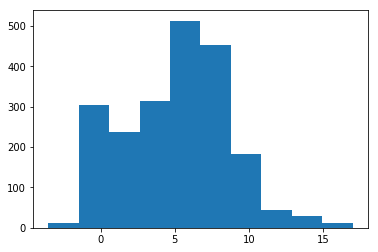

In [292]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(shutter_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]));

In [293]:
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [294]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 4
fl_cutoff = -5000

In [295]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

68.0% data discarded


In [296]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

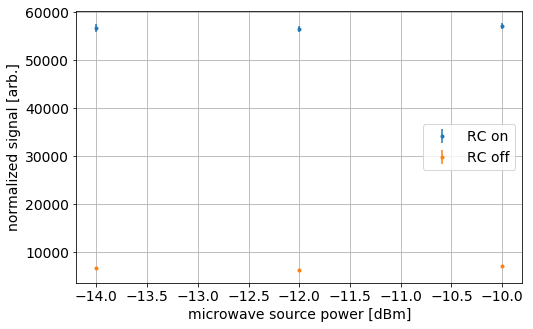

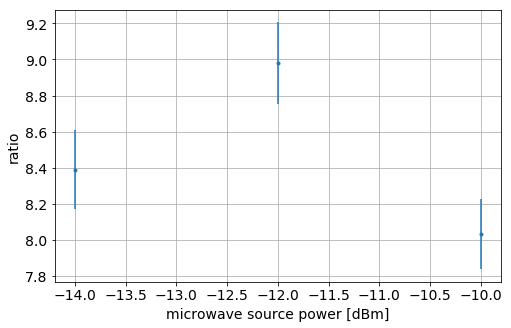

In [297]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('microwave source power [dBm]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan J23 microwave power
R0 F1 DET  
P2 F1 RC  
1.5 MHz pol switching

In [298]:
dset_name = dset_names[15]
devices = ()

In [299]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616534841.6171634
run_description           -> scan microwave power J23 with phase modulation on RC and DET (R0 F1 DET P2 F1 RC J12 J23 microwaves)
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 47 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 26 dBm
microwave_power_j23       -> 24 dBm
npasses                   -> 13


In [300]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [301]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

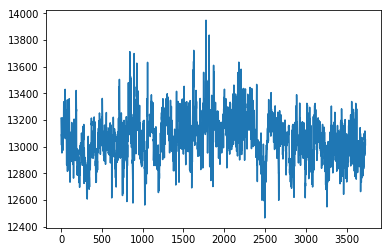

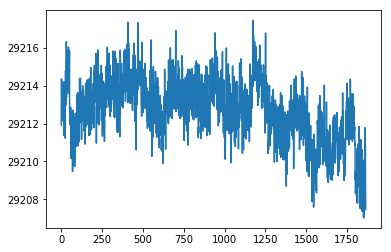

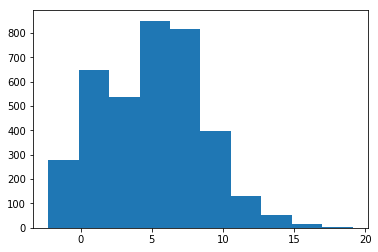

In [302]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(shutter_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]));

In [303]:
scan_parameter = 'SynthHD Pro SetPowerCHBGUI'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [304]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 4
fl_cutoff = -5000

In [305]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

40.5% data discarded


In [306]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


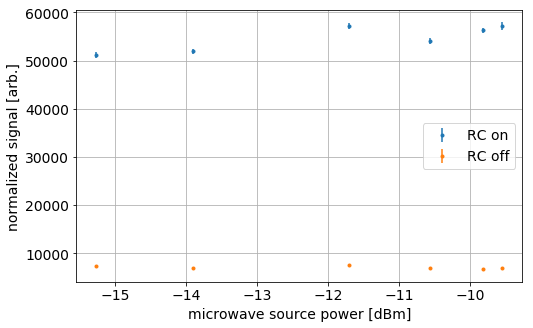

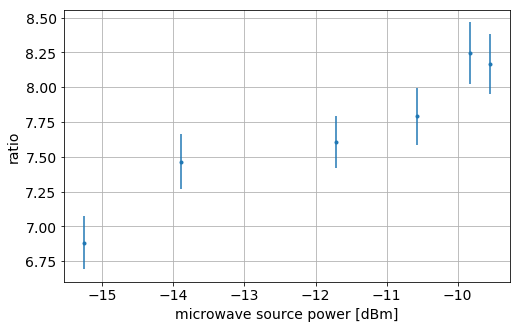

In [307]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('microwave source power [dBm]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave source power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan Polarization Switching Frequency
R0 F1 DET  
P2 F1 RC

In [317]:
dset_name = dset_names[16]
devices = ()

In [318]:
with h5py.File(hdf_dir / fname) as f:
    dset = f[dset_name]
    for attr, val in dset.attrs.items():
        print(f"{attr:<25} -> {val}")

time_offset               -> 1616536451.4089854
run_description           -> scan pol switch freq with phase modulation on RC and DET (R0 F1 DET P2 F1 RC J12 J23 microwaves)
amplification             -> 125
lowpass                   -> 10 kHz
det_power                 -> 50 mW
det_pol_freq              -> 1.56 MHz
rc_power_after_eom        -> 47 mW
rc_pol_freq               -> 1.5 MHz
channels                  -> yag, pmt, abs, absn, shutter, RC pd
shutter_freq              -> 5 Hz
microwave_power_horn_j12  -> 26 dBm
microwave_power_j23       -> 21 dBm
npasses                   -> 13


In [319]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [320]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

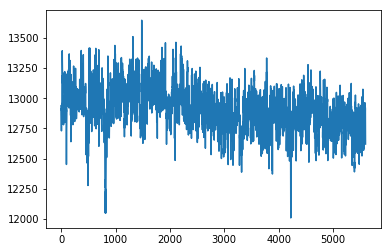

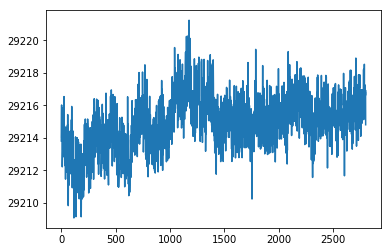

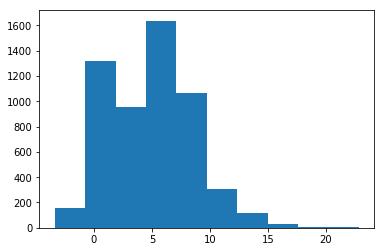

In [321]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(shutter_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]));

In [322]:
scan_parameter = 'BK4063 SetChannel1Frequency'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [323]:
yag_cutoff = 250
ptn_cutoff = 12000
abs_cutoff = 4
fl_cutoff = -5000

In [324]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

39.4% data discarded


In [327]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)/1e6

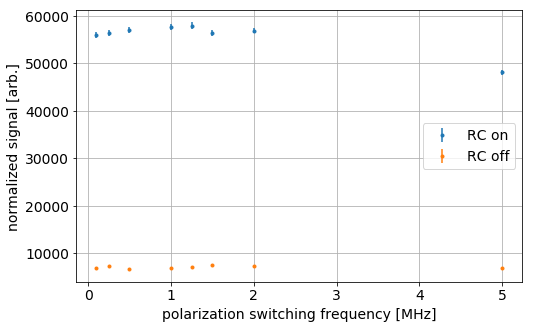

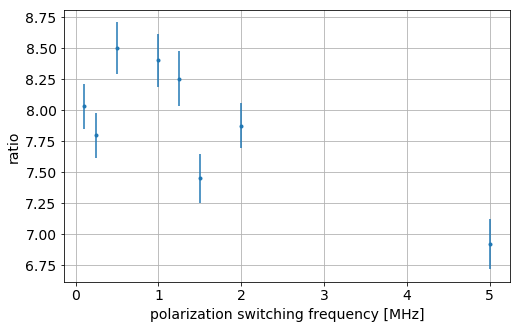

In [329]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)